# Ước lượng giá trị tham chiếu cho xét nghiệm bằng mô hình XGBoost Gamma

### BS. Lê Ngọc Khả Nhi

# Nhập đề:

Trong bài thực hành hôm nay, Nhi sẽ trình diễn khả năng của mô hình hồi quy Gamma XGboost ứng dụng cho một nghiên cứu y học. Tình huống giả định như sau: Một nhóm chuyên gia tại quốc gia X muốn xây dựng một bộ giá trị tham chiếu cho mức tiêu thụ oxy tối đa (VO2max) trong nghiệm pháp gắng sức tim mạch-hô hấp. Bộ giá trị tham chiếu này có dạng một mô hình hồi quy dựa trên dữ liệu của hơn 4000 người khỏe mạnh từ nhiều bệnh viện khác nhau của quốc gia X này. Mô hình nhận giá trị đầu vào là Tuổi, Giới tính, cân nặng, chiều cao, BMI, dựa vào đó ước lượng giá trị VO2max trung bình ở người khỏe mạnh cho một bệnh nhân bất kì; từ đó người bác sĩ sẽ đối chiếu với kết quả thực của bệnh nhân đó và cho phép diễn giải kết quả xét nghiệm của người đó là bình thường hay bệnh lý.

Cho bài toán trên, người ta vẫn thường dùng các mô hình hồi quy tuyến tính với độ phức tạp khác nhau; tuy nhiên trong thí nghiệm sau đây chúng ta sẽ áp dụng mô hình hồi quy XGBoost với phân phối Gamma để giải quyết bài toán.

In [1]:
warning_status = "ignore"
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedKFold

from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

from sklearn import tree
from dtreeviz.trees import *

%config InlineBackend.figure_format = 'png'

# Bước 1: Chuẩn bị dữ liệu

Dữ liệu cho thí nghiệm là file Data.csv, có thể tải từ github:
https://raw.githubusercontent.com/kinokoberuji/Statistics-Python-Tutorials/master/Data.csv

Sau khi tải về, Nhi thực hiện một số hoán chuyển:

+ Đổi đơn vị đo của VO2max từ ml/phút sang Lít/phút
+ Chuyển đổi biến Sex (giá trị Male/Female) thành biến nhị phân: Sex_M nhận giá trị 0 = Nữ, 1 = Nam

Dữ liệu gồm 4408 đơn vị quan sát.

In [2]:
df = pd.read_csv('Data.csv', sep = ';').dropna(how = 'any', axis = 0)

df['VO2max'] = 0.001 * df['VO2max']
df = pd.get_dummies(df, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4408 entries, 0 to 4409
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     4408 non-null   float64
 1   Weight  4408 non-null   float64
 2   Height  4408 non-null   float64
 3   BMI     4408 non-null   float64
 4   VO2max  4408 non-null   float64
 5   Sex_M   4408 non-null   uint8  
dtypes: float64(5), uint8(1)
memory usage: 210.9 KB


In [3]:
df.head()

,Age,Weight,Height,BMI,VO2max,Sex_M
0,14.285620,63.0,172.0,21.295295,2.112,0
1,16.755154,68.0,174.0,22.460034,2.882,0
2,17.999510,57.0,161.0,21.989892,2.027,0
3,17.520976,83.0,182.0,25.057360,2.971,0
4,19.258756,60.0,177.0,19.151585,1.520,0


# Bước 2: Thăm dò dữ liệu

## Phạm vi áp dụng mô hình

Một thông tin quan trọng cần xác định trong bài toán xây dựng mô hình giá trị tham chiếu, đó là những giá trị Min/Max của Tuổi, Chiều cao, cân nặng, BMI; vì chúng cho biết phạm vi áp dụng của mô hình cho quần thể đích; 

thí dụ dựa vào kết quả mô tả, ta có thể dự kiến rằng mô hình hồi quy có thể áp dụng cho mọi bệnh nhân từ 7 đến 66 tuổi; trong giới hạn chiều cao từ 122 đến 205 cm, cân nặng từ 24 đến 122 kg; BMI từ 12.9 đến 30.56.

In [6]:
df.drop('Sex_M', axis = 1).describe()

,Age,Weight,Height,BMI,VO2max
count,4408.000000,4408.000000,4408.000000,4408.000000,4408.000000
mean,34.688639,79.073956,179.543557,24.383153,3.410418
std,11.560585,13.029072,9.494862,2.768856,0.855978
min,7.640424,24.000000,122.000000,12.903226,0.939000
25%,25.672336,72.000000,174.000000,22.598140,2.830000
50%,33.591136,80.000000,180.000000,24.489796,3.520000
75%,43.571890,88.000000,186.000000,26.277285,4.008500
max,65.786897,122.000000,205.000000,30.555556,6.140000


In [4]:
df.groupby('Sex_M').agg(['min','max','median']).T

Sex_M                   0           1
Age    min       7.640424   11.121501
       max      65.786897   64.961339
       median   31.471805   34.071092
Weight min      24.000000   37.000000
       max      98.000000  122.000000
       median   65.500000   83.000000
Height min     122.000000  156.000000
       max     190.000000  205.000000
       median  169.500000  183.000000
BMI    min      12.903226   15.203813
       max      30.483158   30.555556
       median   22.476269   24.933720
VO2max min       0.939000    1.470000
       max       4.516000    6.140000
       median    2.287490    3.720000

## Khảo sát trực quan liên hệ giữa VO2max và các biến đầu vào

Tiếp theo, Nhi viết 1 hàm cho phép kết hợp biểu đồ mật độ phân phối, biểu đồ tán xạ và đường hồi quy để khảo sát trực quan: phân phối của mỗi biến định lượng giữa 2 giới tính Nam/Nữ, và mối tương quan giữa biến kết quả VO2max và mỗi biến số khác.

In [7]:
def joint_plot(feature: str,
               factor: str,
               target: str,
               df: pd.DataFrame,
               col_dict = {0:'#e00b41',1:'#0b96e0'}):
    
    plt.rcParams.update({'font.size': 10})
    plt.figure(1, figsize=(7,7))
    
    left, bottom = 0.01, 0.1
    w_kde = h_kde = 0.2
    left_h = left + w_kde + 0.01
    width = height = 0.65
    bottom_h = bottom + height + 0.01

    rect_y = [left, bottom, w_kde - 0.06, height]
    rect_main = [left_h, bottom, width, height]
    rect_x = [left_h, bottom_h, width, h_kde]

    ax_main = plt.axes(rect_main)
    ax_x = plt.axes(rect_x)
    ax_y = plt.axes(rect_y)
    
    for i in [0,1]:
        dfi = df[df[factor] == i]

        sns.kdeplot(dfi[feature], 
                    ax = ax_x, 
                    shade = True, 
                    color = col_dict[i],
                    alpha = 0.3)
    
        sns.kdeplot(dfi[target], 
                    ax = ax_y,
                    color = col_dict[i],
                    vertical = True, 
                    shade = True, 
                    alpha = 0.3)

        sns.regplot(x = dfi[feature].values,
                        y = dfi[target].values,
                        label = lab_dict[i],
                        scatter = True,
                        marker = '.',
                        x_jitter = 0.3,
                        y_jitter = 0.1,
                        lowess = True,
                        scatter_kws = {'alpha':0.1},
                        line_kws = {'alpha':0.8},
                        color = col_dict[i],
                        ax = ax_main)
    
    ax_main.set_xlabel(feature)
    ax_main.set_ylabel(target)
    ax_y.invert_xaxis()
    ax_main.legend()
    plt.tight_layout()
    ax_y.axis('off')
    ax_x.axis('off')
    
    plt.show()

Sử dụng dictionary là 1 thủ thuật cho phép hiển thị tên biến bằng tiếng Việt mà không thay đổi dữ liệu gốc.

In [8]:
lab_dict = {1: 'Nam', 0: 'Nữ'}
feat_names = ['Tuổi', 'Cân nặng', 'Chiều cao', 'BMI']
col_dict = {0:'#e00b41',
            1:'#0b96e0'}

Ta thấy: VO2max ở nam cao hơn ở nữ, VO2max có liên hệ với BMI theo quy luật phi tuyến tính

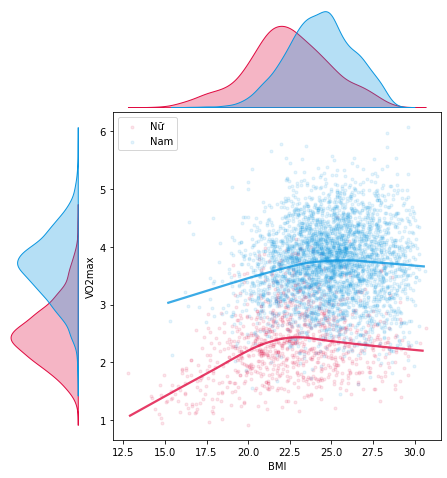

In [7]:
joint_plot(feature = 'BMI',
           factor = 'Sex_M',
           target = 'VO2max',
           df = df,
           col_dict = {0:'#e00b41',1:'#0b96e0'})

Tương tự như mọi đại lượng sinh lý học khác, VO2max thay đổi theo tuổi với quy luật phi tuyến tính chia ra làm 3 giai đoạn: giai đoạn tăng trưởng ở trẻ em và vị thành niên, giai đoạn bình nguyên ở thanh niên và tuổi trung niên, và giai đoạn suy giảm ở người cao tuổi.

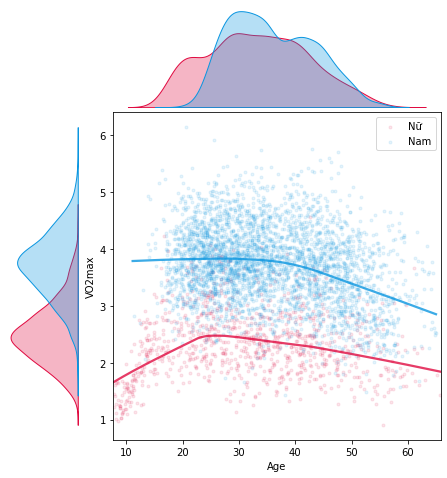

In [8]:
joint_plot(feature = 'Age',
           factor = 'Sex_M',
           target = 'VO2max',
           df = df,
           col_dict = {0:'#e00b41',1:'#0b96e0'})

VO2max liên hệ gần như tuyến tính với Chiều cao

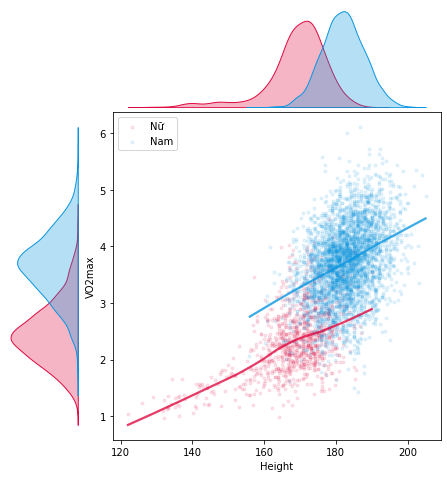

In [10]:
joint_plot(feature = 'Height',
           factor = 'Sex_M',
           target = 'VO2max',
           df = df,
           col_dict = {0:'#e00b41',1:'#0b96e0'})

VO2max cũng tỉ lệ thuận với cân nặng:

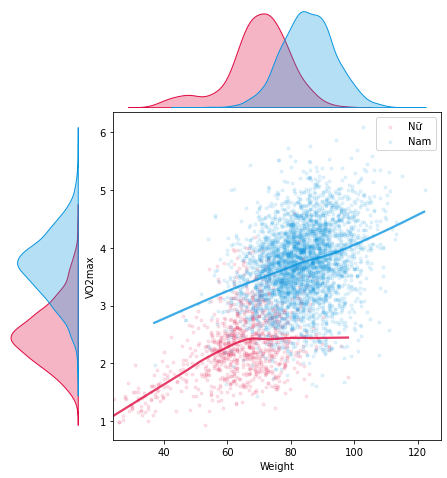

In [11]:
joint_plot(feature = 'Weight',
           factor = 'Sex_M',
           target = 'VO2max',
           df = df,
           col_dict = {0:'#e00b41',1:'#0b96e0'})

# Bước 3: Biện luận phương pháp

Tại sao chúng ta lại dùng XGboost Gamma như giải pháp cho bài toán hồi quy này ? Nhi đã quyết định dựa trên 3 lập luận sau đây:


1) XGBoost là thuật toán Machine learning ưu thế cho dữ liệu dạng bảng, do là 1 mô hình đa dụng, nó có thể giải quyết tốt cả bài toán hồi quy 'regression) lẫn phân nhóm (classification)

2) Biến kết quả là số dương, liên tục; nên ta có thể áp dụng phân phối Gamma cho bài toán hồi quy này.

3) Những ưu điểm của XGboost so với mô hình GLM, GAM hoặc GAMLSS bao gồm:

+ Không cần bất cứ giả thuyết nào về hàm đa thức (polynomial), mô hình XGboost dựa trên thuật toán Cây hồi quy (regression tree) nên tự có khả năng thể hiện các quy luật biến thiên phi tuyến tính phức tạp nhất.

+ Không cần phải dựng riêng 2 mô hình cho nhóm đối tượng Nam và Nữ, hoặc trẻ em/người lớn như khi dùng GLM; biến giới tính và tuổi được xử lý đồng thời với các biến còn lại.

+ Không cần phải quan tâm về hoán chuyển dữ liệu đầu vào (thí dụ bằng hàm logarithm) như trong mô hình GLM, mô hình XGboost sử dụng trực tiếp thang đo nguyên thủy của mọi biến đầu vào.

# Bước 4: Ước tính cỡ mẫu cần thiết cho tập train

Nhi sử dụng phương pháp learning curve để khảo sát tương quan giữa hiệu năng của 1 mô hình XGboost hồi quy (đánh giá bằng trị số neg_mean_absolute_error trên 10% dữ liệu, kiểm định chéo lặp lại) và cỡ mẫu của tập train.

In [73]:
cv = ShuffleSplit(n_splits=50,
                  test_size=0.1,
                  random_state=123)

def learning_curve_experiment(split_interval =  np.linspace(.1, 1.0, 20),
                              cv = cv,
                              estimator = None,
                              X_train =  None,
                              y_train = None):
    
    sample_size, _, test_scores, = learning_curve(estimator, 
                                                  X = X_train, 
                                                  y = y_train, 
                                                  cv=cv, 
                                                  scoring = 'neg_mean_absolute_error',
                                                  train_sizes=split_interval)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    return sample_size, test_scores_mean, test_scores_std

def plot_learning_curve(split_interval =  np.linspace(.1, 1.0, 20),
                        cv = cv,
                        estimator = None,
                        X_train = X_train,
                        y_train = y_train,
                        title = 'Learning curve'):
    
    sample_size, test_scores_mean, test_scores_std = learning_curve_experiment(split_interval,
                                                cv,
                                                estimator,
                                                X_train = X_train,
                                                y_train = y_train)
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_title(title)
    ax.set_xlabel("Kích thước tập huấn luyện")
    ax.set_ylabel("Điểm số")
    
    # Plot learning curve
    ax.grid()
    
    ax.fill_between(sample_size, 
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, 
                    alpha=0.2,
                    color="r")
    
    ax.plot(sample_size, 
            test_scores_mean, 
            'o-', 
            color="r",
            label="Kiểm định chéo")
    
    ax.legend(loc="best")
    
    plt.show()

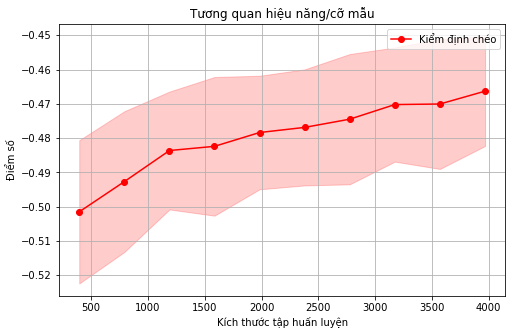

In [75]:
estimator = XGBRegressor(objective = 'reg:gamma',
                       gamma = 0.001,
                       n_estimators = 300,
                       learning_rate = 0.3,
                       max_depth = 5,
                       min_child_weight = 1,
                       grow_policy = "lossguide",
                       tree_method = 'gpu_hist',
                       eval_metric = 'gamma-nloglik',
                       booster = 'dart',
                       predictor = 'gpu_predictor')

plot_learning_curve(split_interval = np.linspace(.1, 1.0, 10),
                    cv = cv,
                    estimator = estimator,
                    X_train = df.drop(['Class','VO2max'], axis = 1).values,
                    y_train = df['VO2max'].values,
                    title = 'Tương quan hiệu năng/cỡ mẫu')

Dựa vào kết quả này, có thể kết luận là ở kích thước tập train từ 3000 đến 3500, độ chính xác của mô hình đã đạt trạng thái tốt nhất có thể. Do đó, ta sẽ dùng 3499 trường hợp (train) và 363 (valid) để dựng mô hình và kiểm định độc lập trên 546 (test).

# Bước 5: phân chia dữ liệu cho thí nghiệm

Để đảm bảo cả 3 tập train, valid và test đều có phân phối của VO2max như nhau, Nhi dùng 1 thủ thuật là phân chia tổng số bệnh nhân thành 5 phần bằng nhau, dựa theo thang đo của VO2max, sau đó phân chia dữ liệu để đảm bảo tỉ lệ của mỗi phân nhóm p1-p5 là như nhau giữa 3 tập train, valid, test

In [13]:
def quantile_split():
    
    q_vo2 = np.quantile(df['VO2max'], q = [i/5 for i in range(5)][::-1])

    vo2_class = {k:f'p_{5-v}' for v,k in enumerate(q_vo2)}

    def grade_mapping(value):
        for k, g in vo2_class.items():
            if value >= k:
                return g

    df['Class'] = df["VO2max"].map(grade_mapping)
    
    train, test, _,_ = train_test_split(df,
                                    df['Class'],
                                    test_size= 1 - 3500/df.shape[0],
                                    random_state=123,)

    valid, test,_,_ = train_test_split(test,
                                    test['Class'],
                                    test_size=0.6,
                                    random_state=123,)
    
    X_train,X_valid,X_test,y_train,y_valid,y_test = train.drop(['Class','VO2max'], axis = 1),\
                                                valid.drop(['Class','VO2max'], axis = 1),\
                                                test.drop(['Class','VO2max'], axis = 1),\
                                                train['VO2max'],valid['VO2max'],test['VO2max']
    
    print(f"Kích thước \n+train: {X_train.shape[0]}, \n+test: {X_test.shape[0]}, \n+valid: {X_valid.shape[0]}")
    
    return df, X_train,X_valid,X_test,y_train,y_valid,y_test

In [14]:
df, X_train,X_valid,X_test,y_train,y_valid,y_test = quantile_split()

Kích thước 
+train: 3499, 
+test: 546, 
+valid: 363


Phân bố VO2max của 5 phân nhóm p1-p5 có thể hình dung như sau:

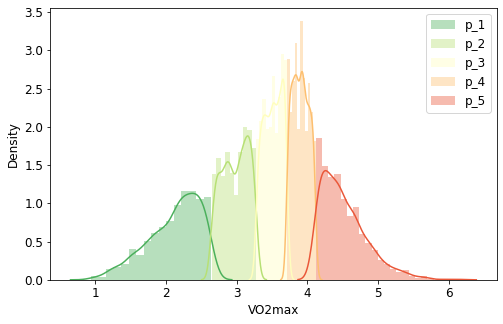

In [39]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 12})
sns.set_palette(sns.color_palette("RdYlGn_r", 5).as_hex())

for i in [f'p_{i+1}' for i in range(5)]:
    sns.distplot(df[df['Class'] == i]['VO2max'], label = i)
    plt.legend()

# Bước 6: Khởi động: Cơ chế của mô hình cây hồi quy

Ta sẽ dùng mô hình XGBoost, đây là 1 mô hình tập hợp gồm rất nhiều đơn vị booster là các mô hình regression tree, chúng được tạo ra nhằm tối ưu hóa độ chính xác dự báo so với giá trị thực. 

Chắc nhiều bạn sẽ ngạc nhiên khi nghe 1 mô hình cây quyết định có thể dự báo giá trị của 1 biến số liên tục ? Điều này hoàn toàn có thể. Tuy VO2max là 1 biến số liên tục, nhưng thang đo của nó có thể phân chia thành rất nhiều mảnh nhỏ, một cây quyết định có thể tối ưu hóa quy tắc phân chia này; trong 1 không gian dữ liệu 2-5 chiều (ta có 5 biến đầu vào). Với tree-depth đủ sâu, mô hình cây có thể định vị khá chính xác các mảnh nhỏ trên thang đo của VO2max. 

Thí nghiệm sau đây sẽ hình ảnh hóa 10 mô hình cây hồi quy chỉ dùng 2 biến đầu vào, với tree-depth = 5; kết quả kiểm định độc lập cho thấy mỗi mô hình đạt giá trị R2 từ 0.2 đến 0.5

Dĩ nhiên mỗi mô hình cây rất yếu, không bao giờ đạt đến độ chính xác tuyệt đối, nhưng khi tập hợp hàng trăm booster yếu này lại, ta sẽ có một mô hình tập hợp đủ mạnh để ước lượng mọi vị trí trên thang đo VO2max.

In [15]:
feats = list(X_train.columns)

feat_names = ['Tuổi (năm)', 'Cân nặng (kg)', 'Chiều cao (cm)', 'BMI (kg/m2)', 'Nam giới']

feat_dict = {k:v for k,v in zip(feats, feat_names)}

In [69]:
def bivar_regplot3D(fea_pair = (0,3), 
                  tar_name = 'VO2max',
                  fig_size = (10,10),
                  font_size = 13,
                  dot_size = 50,
                  X = None, 
                  y = None,
                  X_plot = None,
                  y_plot = None,
                  depth = 5):
    
    pair_name = [feat_dict[feats[fea_pair[0]]], feat_dict[feats[fea_pair[1]]]]
    
    tm = tree.DecisionTreeRegressor(max_depth=depth)
    tm.fit(X, y)
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    t = rtreeviz_bivar_3D(tree_model = tm,
                      ax = ax,
                      x_data = X_plot, 
                      y_data = y_plot,
                      feature_names = pair_name,
                      target_name = tar_name,
                      fontsize=font_size,
                      elev=30,
                      azim=-50,
                      dist=10,
                      markersize=dot_size,
                      show={'splits','title'})

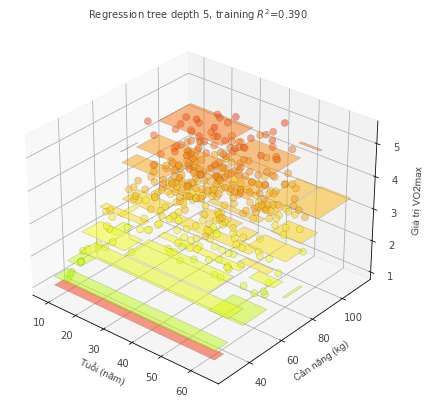

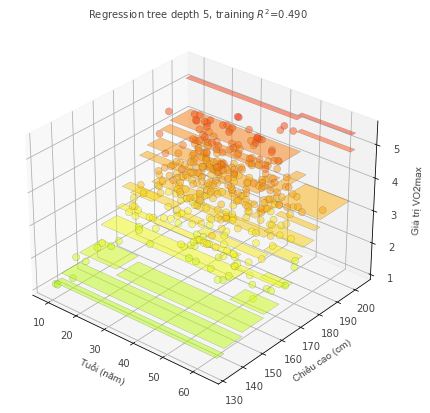

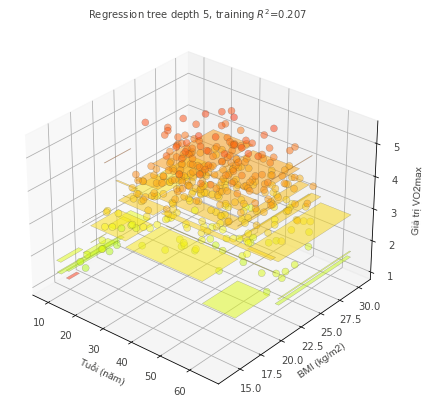

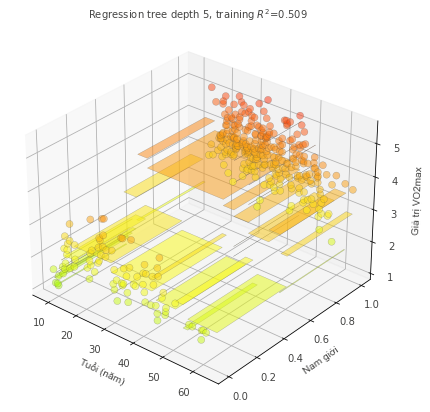

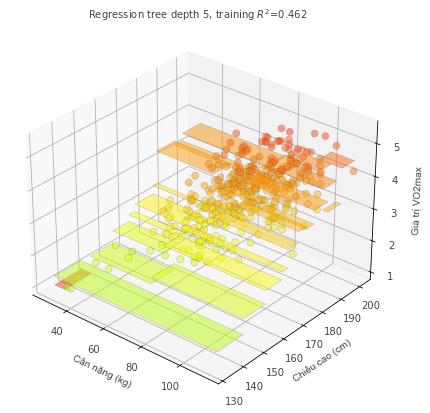

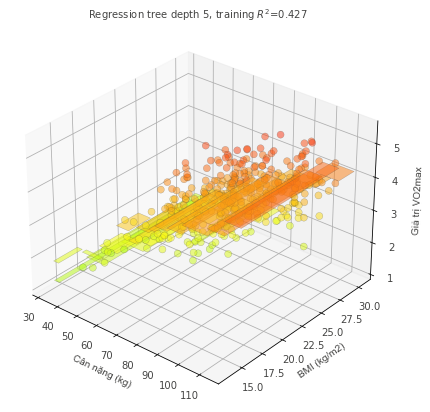

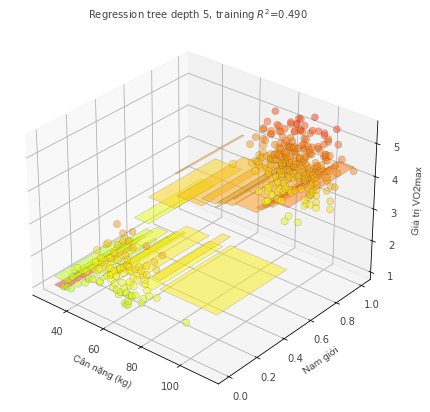

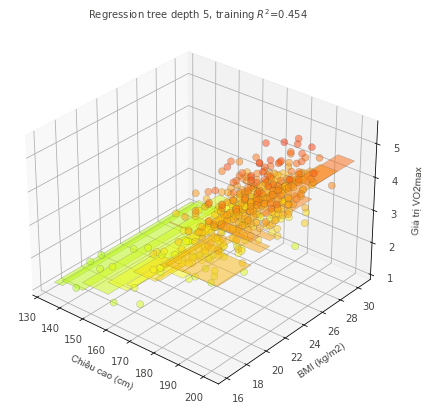

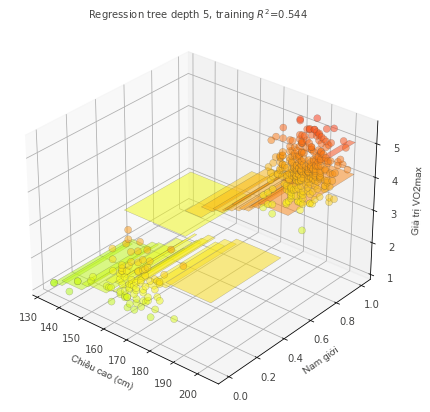

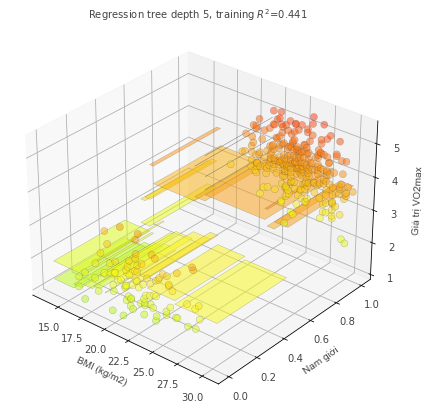

In [72]:
comb = combinations(range(len(feats)),2)

for fea_pair in comb:
    X,y = X_train.values[:,fea_pair], y_train
    
    bivar_regplot3D(fea_pair = fea_pair, 
                    tar_name = 'Giá trị VO2max',
                    fig_size = (7,7),
                    font_size = 10,
                    dot_size = 50,
                    X = X, 
                    y = y,
                    X_plot = X_valid.values[:,fea_pair],
                    y_plot = y_valid,
                    depth = 5)

# Bước 7 : Huấn luyện mô hình hồi quy XGBoost

Bây giờ, ta thực sự huấn luyện 1 mô hình XGBoost hồi quy, trên tập train và valid: Kết quả cho thấy chỉ sau khoảng 30 lượt huấn luyện, mô hình đã đạt trạng thái tối ưu với gamma-nloglik = 2.20

In [76]:
xgb_mod = XGBRegressor(objective = 'reg:gamma',
                       gamma = 0.001,
                       n_estimators = 500,
                       learning_rate = 0.2,
                       max_depth = 7,
                       min_child_weight = 1,
                       subsample = 0.65,
                       grow_policy = "lossguide",
                       tree_method = 'gpu_hist',
                       eval_metric = 'gamma-nloglik',
                       booster = 'dart',
                       predictor = 'gpu_predictor')

xgb_mod.fit(X = X_train.values,
            y = y_train.values, 
            eval_set = [(X_valid.values, y_valid.values)],
            early_stopping_rounds=10,
            eval_metric="gamma-nloglik",
            verbose = True)

[0]	validation_0-gamma-nloglik:5.21520
Will train until validation_0-gamma-nloglik hasn't improved in 10 rounds.
[1]	validation_0-gamma-nloglik:4.50682
[2]	validation_0-gamma-nloglik:3.95010
[3]	validation_0-gamma-nloglik:3.51642
[4]	validation_0-gamma-nloglik:3.18107
[5]	validation_0-gamma-nloglik:2.92416
[6]	validation_0-gamma-nloglik:2.72953
[7]	validation_0-gamma-nloglik:2.58277
[8]	validation_0-gamma-nloglik:2.47443
[9]	validation_0-gamma-nloglik:2.39501
[10]	validation_0-gamma-nloglik:2.33718
[11]	validation_0-gamma-nloglik:2.29555
[12]	validation_0-gamma-nloglik:2.26684
[13]	validation_0-gamma-nloglik:2.24633
[14]	validation_0-gamma-nloglik:2.23211
[15]	validation_0-gamma-nloglik:2.22258
[16]	validation_0-gamma-nloglik:2.21589
[17]	validation_0-gamma-nloglik:2.21174
[18]	validation_0-gamma-nloglik:2.20864
[19]	validation_0-gamma-nloglik:2.20641
[20]	validation_0-gamma-nloglik:2.20504
[21]	validation_0-gamma-nloglik:2.20427
[22]	validation_0-gamma-nloglik:2.20374
[23]	validation_

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_metric='gamma-nloglik', gamma=0.001, gpu_id=0,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0)', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:gamma',
             predictor='gpu_predictor', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=0.65,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Text(0.5, 1.0, 'Diễn tiến huấn luyện')

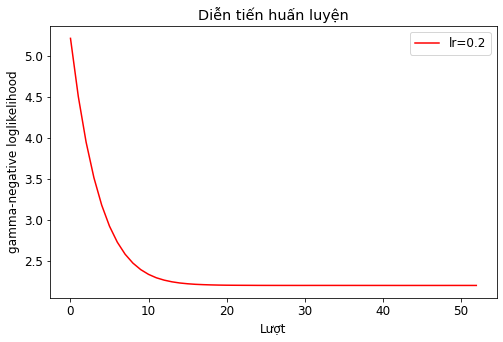

In [77]:
results = xgb_mod.evals_result()

epochs = len(results['validation_0']['gamma-nloglik'])
x_axis = range(0, epochs)
    
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 12})
    
g=plt.plot(x_axis,
           results['validation_0']['gamma-nloglik'], 
           'r-',
           label='lr=0.2')
    
plt.legend()
plt.ylabel('gamma-negative loglikelihood')
plt.xlabel('Lượt')
plt.title('Diễn tiến huấn luyện')

# Bước 8: Kiểm định độc lập mô hình hồi quy

## Khả năng tái hiện phân phối VO2max trên tập test

Khi đối chiếu phân phối của giá trị ước lượng so với giá trị thực, ta thấy mô hình hoạt động khá chính xác cho phạm vi VO2max từ thấp nhất là 0 đến 5 L/phút; nhưng bắt đầu có sai sót ở những giá trị VO2max cao nhất từ 5-6. Như mọi mô hình hồi quy khác, mô hình XGboost chỉ có thể làm tốt nhất khi tái hiện giá trị trung vị của biến kết quả trong quần thể.

[Text(0.5, 0, 'Giá trị VO2max')]

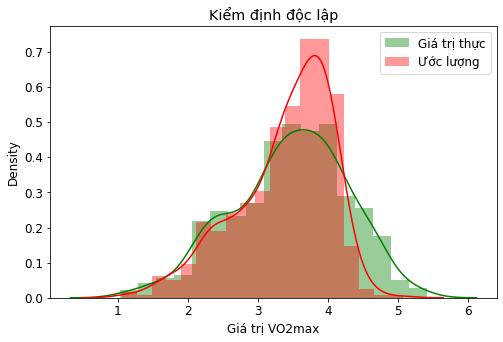

In [78]:
test_pred = xgb_mod.predict(X_test.values)

plt.rcParams["figure.figsize"] = (8,5)
plt.title('Kiểm định độc lập')

g = sns.distplot(y_test.values,
            label = 'Giá trị thực',
            color = 'green')

g = sns.distplot(test_pred,
            label = 'Ước lượng',
            color = 'red')

g.legend()
g.set(xlabel='Giá trị VO2max')

## Khả năng tái hiện khuynh hướng của VO2max so với tuổi, BMI ở 2 giới tính

Tiếp theo, Nhi tạo 1 dataframe ba_df với toàn bộ dữ liệu tập test, cộng thêm giá trị VO2max dự báo bởi mô hình; 

In [84]:
q_vo2 = np.quantile(df['VO2max'], q = [i/5 for i in range(5)][::-1])
vo2_class = {k:f'p_{5-v}' for v,k in enumerate(q_vo2)}
def grade_mapping(value):
    for k, g in vo2_class.items():
        if value >= k:
            return g

ba_df = pd.DataFrame({'ID': X_test.index,
                      'Age': X_test['Age'],
                      'Weight': X_test['Weight'],
                      'Height': X_test['Height'],
                      'BMI': X_test['BMI'],
                      'Sex_M': X_test['Sex_M'],
                      'Ref': y_test.values,
                      'Target': test_pred,
                      'Difference' : test_pred - y_test.values,
                     'Class': pd.Series(y_test).map(grade_mapping)}
                      )

ba_df

,ID,Age,Weight,Height,BMI,Sex_M,Ref,Target,Difference,Class
2330,2330,23.908493,88.0,189.0,24.635369,1,4.1200,4.215194,0.095194,p_5
2128,2128,21.325985,73.0,180.0,22.530864,1,3.3800,3.763651,0.383651,p_3
4324,4324,51.224376,89.0,186.0,25.725517,1,4.6980,3.447308,-1.250692,p_5
4048,4048,33.192576,86.0,183.0,25.680074,1,4.9740,3.941329,-1.032671,p_5
2222,2222,22.529081,71.0,188.0,20.088275,1,3.7400,3.776568,0.036568,p_4
...,...,...,...,...,...,...,...,...,...,...
2245,2245,22.697601,82.0,185.0,23.959094,1,4.1700,4.202915,0.032915,p_5
805,805,9.717970,40.0,146.0,18.765247,0,1.3300,1.619933,0.289933,p_1
3718,3718,43.054603,89.0,180.0,27.469136,1,3.8300,3.529793,-0.300207,p_4
4272,4272,48.662405,73.0,185.0,21.329438,1,3.9360,3.391883,-0.544117,p_4


In [96]:
def vpc_plot(ba_df: pd.DataFrame):
    
    lab_dict = {1: 'Nam', 0: 'Nữ'}
    feat_names = ['Tuổi', 'Cân nặng', 'Chiều cao', 'BMI']
    col_dict_p = {0:'#e00b41',
                1:'#0b96e0'}
    col_dict_t = {0 : 'red',
                  1: 'blue'}

    plt.rcParams["figure.figsize"] = (9,9)
    plt.rcParams.update({'font.size': 11})

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(hspace=0.15)
    fig.suptitle('Tương quan giữa VO2max dự báo và 4 features')

    for ax,feature,name in zip(axes.flatten(), 
                               ['Age','Height','Weight','BMI'],
                               feat_names):
        for i in [0,1]:
            dfi = ba_df[df['Sex_M'] == i]
            sns.regplot(x = dfi[feature].values,
                        y = dfi['Ref'].values,
                        scatter = True,
                        marker = '.',
                        x_jitter = 0.3,
                        y_jitter = 0.1,
                        lowess = True,
                        scatter_kws = {'alpha':0.2},
                        line_kws = {'alpha':0.0},
                        color = col_dict_p[i],
                        ax = ax)

            sns.regplot(x = dfi[feature].values,
                        y = dfi['Target'].values,
                        scatter = False,
                        marker = '.',
                        x_jitter = 0.3,
                        y_jitter = 0.1,
                        lowess = True,
                        label = f'{lab_dict[i]} dự báo',
                        scatter_kws = {'alpha':0.0},
                        line_kws = {'alpha':0.8},
                        color = col_dict_p[i],
                        ax = ax)

            sns.regplot(x = dfi[feature].values,
                        y = dfi['Ref'].values,
                        label = f'{lab_dict[i]} thực',
                        scatter = False,
                        lowess = True,
                        scatter_kws = {'alpha':0.0},
                        line_kws = {'alpha':0.8, 'linestyle':'--'},
                        color = col_dict_t[i],
                        ax = ax)

            ax.set_xlabel(name)
            ax.set_ylabel('VO2max')
            ax.legend()

    plt.tight_layout()
    plt.show()

Sau đó Nhi viết 1 hàm cho phép khảo sát trực quan các đồ thị phi tuyến tính giữa VO2max tùy theo các biến khác, và so sánh 2 đồ thị trên dữ liệu thực và dữ liệu dự báo:

Kết quả cho thấy mô hình đã tái hiện hoàn hảo quy luật diễn tiến của VO2max ở 3 giai đoạn: tăng trưởng ở trẻ em, cân bằng ở trung niên và suy giảm ở người già; nó cũng tái hiện rất trung thành liên hệ giữa VO2max và BMI.

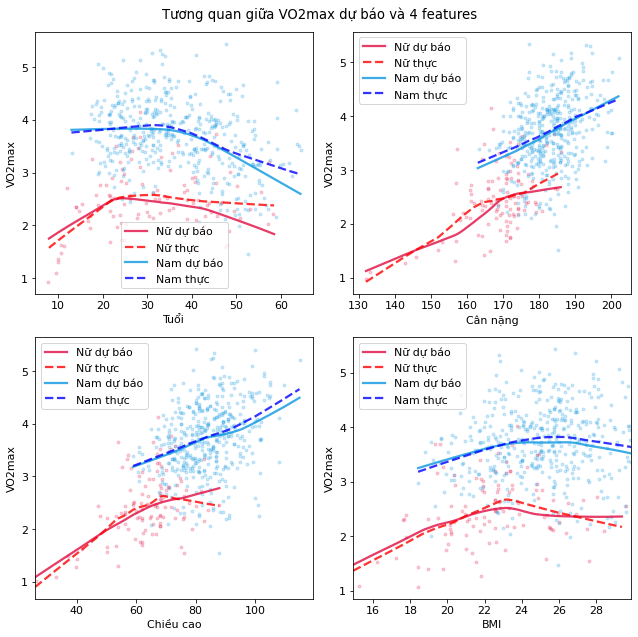

In [97]:
vpc_plot(ba_df)

## Tương quan tuyến tính giữa giá trị thực tế và dự báo

Trên tập kiểm định, VO2max dự báo tương quan khá tốt với giá trị thực tế, với r = 0.714

[Text(0.5, 0, 'Giá trị thực tế VO2max'),
 Text(0, 0.5, 'Giá trị ước lượng VO2max')]

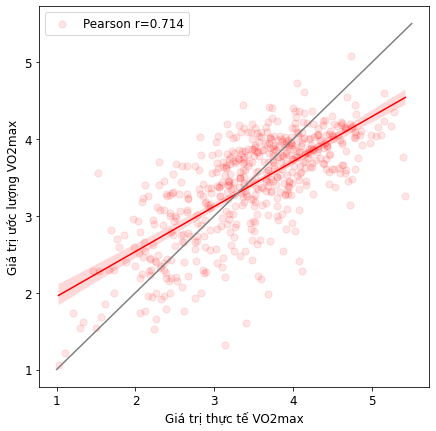

In [95]:
plt.figure(figsize=(7,7))

from scipy.stats import pearsonr

plt.rcParams.update({'font.size': 12})

g = sns.regplot('Ref',
            'Target',
            data = ba_df,
            lowess = False,
            scatter_kws={'alpha':0.1,'color':'red','s': 50},
            label = f"Pearson r={pearsonr(ba_df['Ref'], ba_df['Target'])[0]:.3}",
            line_kws={'color': 'red', 'lw':1.5}
            )

sns.lineplot([1,5.5],[1,5.5], color = 'grey')

g.set(xlabel = 'Giá trị thực tế VO2max', ylabel = 'Giá trị ước lượng VO2max')

## Sai số của mô hình trong từng khoảng giá trị

Các bạn còn nhớ chúng ta đã chia thang đo VO2max thành 5 phân vùng, tiếp theo ta sẽ ước tính 4 trị số RMSE (root mean squared error), MSE (mean squared error), MEDAE (trung vị sai số tuyệt đối) và, MAE (trung bình sai số tuyệt đối) cho mỗi phân vùng.

Kết quả khẳng định quan sát của ta trên biểu đồ mật độ phân bố: Sai số của mô hình thấp nhất ở khu vực trung vì và VO2max thấp, nhưng tăng cao ở phân vùng p5 nơi có VO2max từ 5-6 L/phút.

In [103]:
def eval_metrics(Y_test = y_test, test_pred = test_pred):
    
    return {'rmse': mean_squared_error(Y_test, test_pred, squared = True),
            'mse': mean_squared_error(Y_test, test_pred, squared = False),
            'medae': median_absolute_error(Y_test, test_pred),
            'mae': mean_absolute_error(Y_test, test_pred),
            }

print('Kiểm định theo phân nhóm')
for i in [f'p_{p+1}' for p in range(5)]:
    print('-'*45)
    temp_df = ba_df[ba_df['Class'] == i]
    print(pd.DataFrame(eval_metrics(temp_df['Ref'].values, 
                                    temp_df['Target'].values), index = [i]))

Kiểm định theo phân nhóm
---------------------------------------------
         rmse       mse     medae       mae
p_1  0.410157  0.640435  0.448393  0.515445
---------------------------------------------
         rmse       mse     medae       mae
p_2  0.287704  0.536381  0.412099  0.447936
---------------------------------------------
         rmse      mse     medae       mae
p_3  0.277877  0.52714  0.325838  0.410796
---------------------------------------------
         rmse       mse     medae       mae
p_4  0.246242  0.496227  0.250643  0.355263
---------------------------------------------
         rmse       mse     medae       mae
p_5  0.492332  0.701664  0.522136  0.606106


# Bước 9: Xây dựng một công cụ diễn giải kết quả xét nghiệm VO2max

Trong một nghiên cứu Machine learning ứng dụng cho y học, ta không bao giờ chỉ dừng lại ở một mô hình trên báo cáo, nhưng phải đi đến tận cùng, tức là chuyển giao cho đồng nghiệp một công cụ có thể hoạt động được trên thực tế.

Cho bài toán này, Nhi dùng Python để tạo 1 class đơn giản cho phép nhận vào 1 array dữ liệu các giá trị Tuổi, Giới tính, Chiều cao, cân nặng, BMI; sau đó sử dụng mô hình để ước tính trung bình dự báo, ngưỡng trên và dưới giá trị bình thường tham chiếu cho VO2max; sau đó đối chiếu với kết quả xét nghiệm thực của bệnh nhân, và tính được điểm số chuẩn hóa sai biệt giữa giá trị thực và dự báo, tỉ lệ % giữa giá trị thực trên trung bình dự báo; và vẽ biểu đồ mật độ phân bố của khoảng bình thường tham chiếu, trên đó định vị 2 giá trị thực và trung bình dự báo.

Ghi chú:

Ngưỡng trên (UL) và dưới (LL) của khoảng bình thường được tính theo công thức:

$$ UL = \mu + 1.645 * RSD $$
$$ UL = \mu - 1.645 * RSD $$

Trong đó $\mu$ là giá trị trung bình dự báo; RSD là SD của sai số mô hình, được ước tính riêng cho mỗi phân vùng p1-p5

In [104]:
residual_df = ba_df.groupby('Class').describe(percentiles = [0.05,0.5,0.95])['Difference']

residual_df

,count,mean,std,min,5%,50%,95%,max
Class,,,,,,,,
p_1,101.0,0.360335,0.532089,-0.859561,-0.444811,0.338905,1.134972,2.035733
p_2,109.0,0.169455,0.511260,-1.809743,-0.690923,0.257177,0.914808,1.202970
p_3,114.0,0.004151,0.529451,-1.790680,-0.947674,0.125445,0.681318,1.069208
p_4,107.0,-0.234500,0.439381,-1.831699,-1.051938,-0.145968,0.326073,0.678148
p_5,115.0,-0.583701,0.391095,-2.166379,-1.158063,-0.522136,-0.032432,0.485479


Sau khi mô hình tính ra được $\mu$, sẽ đối chiếu với ngưỡng phân chia của p1-p5 để gán 1 nhãn giá trị p1-p5 cho kết quả, sau đó tải RSD tương ứng để tính UL, LL

In [105]:
vo2_class

{4.12: 'p_5',
 3.7142: 'p_4',
 3.2800000000000002: 'p_3',
 2.6472: 'p_2',
 0.9390000000000001: 'p_1'}

In [106]:
rsd_dict = {k: v for k, v in zip(list(residual_df['std'].index),
                                 list(residual_df['std'].values))}

rsd_dict

{'p_1': 0.5320885584888408,
 'p_2': 0.511260407848357,
 'p_3': 0.5294510707500787,
 'p_4': 0.4393812929693142,
 'p_5': 0.3910953503259006}

In [115]:
def grade_mapping(value=0.):
    for k, g in vo2_class.items():
        if value >= k:
            return g
        
class Inperpret_VO2max():
    
    def __init__(self, X, model, obs, n_iter=5000):
        self.obs = obs,
        self.X = np.array(X).reshape(1,5)
        self.mu = float(model.predict(self.X))
        self.grade = pd.Series(4.0).map(grade_mapping)[0]
        np.random.seed(123)
        self.rsd = rsd_dict[self.grade]
        self.sample = np.random.normal(self.mu, self.rsd, n_iter)
        self.ci95 = np.quantile(self.sample[self.sample >= 0], q=[0.05, 0.95])

    def report(self):
        
        print(f'''
        Kết quả xét nghiệm VO2max:
        Giá trị thực tế = {self.obs[0]}
        Giá trị lý thuyết = {self.mu:.5}
        Ngưỡng bình thường : Trên = {self.ci95[1]:.5}
                             Dưới = {self.ci95[0]:.5}
        Tỉ lệ = {100*self.obs[0]/self.mu:.5}%
        Z_score = {(self.obs[0] - self.mu)/self.rsd:.5}''')
        
    def plot_normal(self):
        plt.rcParams["figure.figsize"] = (8,3)
        plt.rcParams.update({'font.size': 10})
        sns.kdeplot(self.sample, shade = True, color = '#84bf1d')
        plt.vlines(ymin = 0, 
                   ymax = 1,
                   x = self.obs,
                   linestyles = 'dashed',
                   color = 'red',
                   label = 'Thực tế',
                   alpha = 0.5)

        plt.vlines(ymin = 0, 
                   ymax = 1,
                   x = self.mu,
                   color = 'blue',
                   linestyles = 'dashed',
                   label = 'Trung bình dự báo',
                   alpha = 0.5)

        plt.xlabel('VO2max')

        plt.legend()

# Bước 10: Sử dụng class diễn giải kết quả

Class Inperpret_VO2max hoạt động trên thực tế như sau:

Trường hợp thứ 1: một bệnh nhân có giá trị xét nghiệm cao hơn so với giá trị tham chiếu, anh ta là người khỏe mạnh.

In [116]:
# X là array 1D theo thứ tự: Age, Weight, Height, BMI, Sex = M(1/0)

ket_qua = Inperpret_VO2max(X = [24.0, 68.5, 175.0, 22.367346938775512, 1],
                 model = xgb_mod,
                 obs = 4.0,
                 n_iter = 5000)

In [117]:
ket_qua.report()


        Kết quả xét nghiệm VO2max:
        Giá trị thực tế = 4.0
        Giá trị lý thuyết = 3.2944
        Ngưỡng bình thường : Trên = 4.016
                             Dưới = 2.5829
        Tỉ lệ = 121.42%
        Z_score = 1.6058


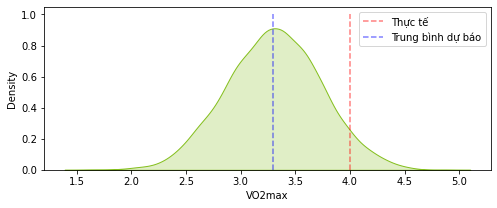

In [118]:
ket_qua.plot_normal()

Một bệnh nhân khác có giá trị xét nghiệm thấp hơn nhiều (66.7%) so với giá trị tham chiếu, với Z-score chỉ có -2.87, như vậy anh ta có vấn đề về chức năng tim mạch/hô hấp.

In [119]:
# X là array 1D theo thứ tự: Age, Weight, Height, BMI, Sex = M(1/0)

ket_qua = Inperpret_VO2max(X = [17.,54.6, 172.,18.4559221200649, 1],
                 model = xgb_mod,
                 obs = 2.4,
                 n_iter = 5000)

In [120]:
ket_qua.report()


        Kết quả xét nghiệm VO2max:
        Giá trị thực tế = 2.4
        Giá trị lý thuyết = 3.6005
        Ngưỡng bình thường : Trên = 4.322
                             Dưới = 2.889
        Tỉ lệ = 66.658%
        Z_score = -2.7322


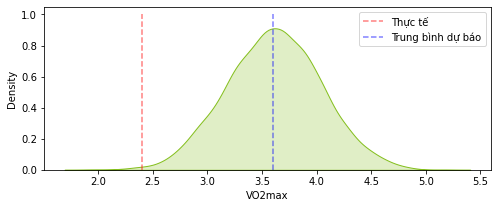

In [121]:
ket_qua.plot_normal()

Bài thực hành đến đây là hết, hẹn gặp lại các bạn lần sau.